In [5]:
# Copyright 2020 - 2021 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import time
import torch
import numpy as np
from monai.inferers import sliding_window_inference
from networks.unetr import UNETR
from utils.data_utils import get_loader
from trainer import dice
import argparse
import matplotlib.pyplot as plt
import itk
from itkwidgets import view

In [6]:
parser = argparse.ArgumentParser(description='UNETR segmentation pipeline')
parser.add_argument('--pretrained_dir', default='./pretrained_models/', type=str, help='pretrained checkpoint directory')
parser.add_argument('--data_dir', default='./dataset/dataset0/', type=str, help='dataset directory')
parser.add_argument('--json_list', default='dataset_0.json', type=str, help='dataset json file')
parser.add_argument('--pretrained_model_name', default='UNETR_model_best_acc.pth', type=str, help='pretrained model name')
parser.add_argument('--saved_checkpoint', default='ckpt', type=str, help='Supports torchscript or ckpt pretrained checkpoint type')
parser.add_argument('--mlp_dim', default=3072, type=int, help='mlp dimention in ViT encoder')
parser.add_argument('--hidden_size', default=768, type=int, help='hidden size dimention in ViT encoder')
parser.add_argument('--feature_size', default=16, type=int, help='feature size dimention')
parser.add_argument('--infer_overlap', default=0.5, type=float, help='sliding window inference overlap')
parser.add_argument('--in_channels', default=1, type=int, help='number of input channels')
parser.add_argument('--out_channels', default=14, type=int, help='number of output channels')
parser.add_argument('--num_heads', default=12, type=int, help='number of attention heads in ViT encoder')
parser.add_argument('--res_block', action='store_true', help='use residual blocks')
parser.add_argument('--conv_block', action='store_true', help='use conv blocks')
parser.add_argument('--a_min', default=-175.0, type=float, help='a_min in ScaleIntensityRanged')
parser.add_argument('--a_max', default=250.0, type=float, help='a_max in ScaleIntensityRanged')
parser.add_argument('--b_min', default=0.0, type=float, help='b_min in ScaleIntensityRanged')
parser.add_argument('--b_max', default=1.0, type=float, help='b_max in ScaleIntensityRanged')
parser.add_argument('--space_x', default=1.5, type=float, help='spacing in x direction')
parser.add_argument('--space_y', default=1.5, type=float, help='spacing in y direction')
parser.add_argument('--space_z', default=2.0, type=float, help='spacing in z direction')
parser.add_argument('--roi_x', default=96, type=int, help='roi size in x direction')
parser.add_argument('--roi_y', default=96, type=int, help='roi size in y direction')
parser.add_argument('--roi_z', default=96, type=int, help='roi size in z direction')
parser.add_argument('--dropout_rate', default=0.0, type=float, help='dropout rate')
parser.add_argument('--distributed', action='store_true', help='start distributed training')
parser.add_argument('--workers', default=8, type=int, help='number of workers')
parser.add_argument('--RandFlipd_prob', default=0.2, type=float, help='RandFlipd aug probability')
parser.add_argument('--RandRotate90d_prob', default=0.2, type=float, help='RandRotate90d aug probability')
parser.add_argument('--RandScaleIntensityd_prob', default=0.1, type=float, help='RandScaleIntensityd aug probability')
parser.add_argument('--RandShiftIntensityd_prob', default=0.1, type=float, help='RandShiftIntensityd aug probability')
parser.add_argument('--pos_embed', default='perceptron', type=str, help='type of position embedding')
parser.add_argument('--norm_name', default='instance', type=str, help='normalization layer type in decoder')

_StoreAction(option_strings=['--norm_name'], dest='norm_name', nargs=None, const=None, default='instance', type=<class 'str'>, choices=None, help='normalization layer type in decoder', metavar=None)

In [7]:
args = parser.parse_args(args=['--infer_overlap', '0.0', 
                                '--data_dir', './dataset/dataset0/',
                                '--pretrained_dir', './pretrained_models/',
                                '--saved_checkpoint', 'ckpt'])

In [8]:
args.test_mode = True
val_loader = get_loader(args)
pretrained_dir = args.pretrained_dir
model_name = args.pretrained_model_name
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

pretrained_pth = os.path.join(pretrained_dir, model_name)
if args.saved_checkpoint == 'torchscript':
    model = torch.jit.load(pretrained_pth)
elif args.saved_checkpoint == 'ckpt':
    model = UNETR(
        in_channels=args.in_channels,
        out_channels=args.out_channels,
        img_size=(args.roi_x, args.roi_y, args.roi_z),
        feature_size=args.feature_size,
        hidden_size=args.hidden_size,
        mlp_dim=args.mlp_dim,
        num_heads=args.num_heads,
        pos_embed=args.pos_embed,
        norm_name=args.norm_name,
        conv_block=True,
        res_block=True,
        dropout_rate=args.dropout_rate)
    model_dict = torch.load(pretrained_pth)
    model.load_state_dict(model_dict)

model.eval() # to do evaluation
model.to(device)

returning test_loader


UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0): TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (drop_output): Dropout(p=0.0, inplace=False)
          (d

In [9]:
slice_map = {
        "dataset\\dataset0\\imagesTr\\img0035.nii.gz": 170,
        "dataset\\dataset0\\imagesTr\\img0036.nii.gz": 230,
        "dataset\\dataset0\\imagesTr\\img0037.nii.gz": 204,
        "dataset\\dataset0\\imagesTr\\img0038.nii.gz": 204,
        "dataset\\dataset0\\imagesTr\\img0039.nii.gz": 204,
        "dataset\\dataset0\\imagesTr\\img0040.nii.gz": 180,
    }

Inference on case dataset\dataset0\imagesTr\img0035.nii.gz


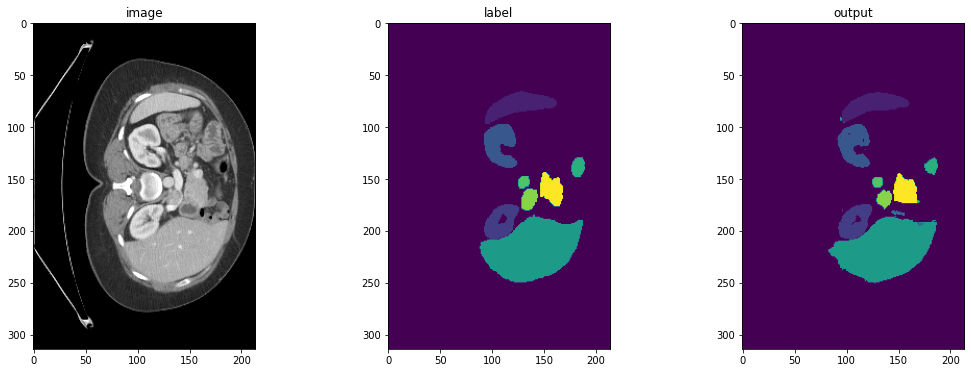

torch.Size([1, 14, 314, 214, 234])
Mean Organ Dice: 0.7136022788046353
--- 112.20632719993591 seconds ---


In [10]:
# overlap = 0.0
val_inputs = _
val_labels = _
val_outputs = _

start_time = time.time()

with torch.no_grad():
    for i, batch in enumerate(val_loader):

        img_name = batch['image_meta_dict']['filename_or_obj'][0].split('/')[-1]
        print("Inference on case {}".format(img_name))

        val_inputs, val_labels = (batch["image"], batch["label"])
        val_outputs = sliding_window_inference(
            val_inputs, (96, 96, 96), 4, model, overlap=args.infer_overlap
        )

        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        plt.imshow(val_inputs.numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels.numpy()[0, 0, :, :, slice_map[img_name]])
        plt.subplot(1, 3, 3)
        plt.title("output")
        plt.imshow(
            torch.argmax(val_outputs, dim=1).detach()[0, :, :, slice_map[img_name]]
        )
        plt.show()

        val_outputs_score = torch.softmax(val_outputs, 1).numpy()
        val_outputs_score = np.argmax(val_outputs_score, axis=1).astype(np.uint8)
        val_labels_score = val_labels.numpy()[:, 0, :, :, :]
        dice_list_sub = []
        for i in range(1, 14):
            organ_Dice = dice(val_outputs_score[0] == i, val_labels_score[0] == i)
            dice_list_sub.append(organ_Dice)
        mean_dice = np.mean(dice_list_sub)
        print(val_outputs.shape)
        print("Mean Organ Dice: {}".format(mean_dice))
        
print("--- %s seconds ---" % (time.time() - start_time))

Inference on case dataset\dataset0\imagesTr\img0035.nii.gz


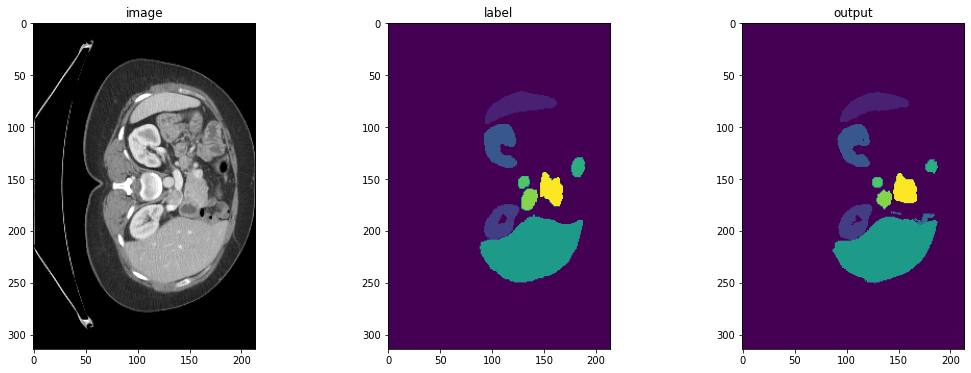

torch.Size([1, 14, 314, 214, 234])
Mean Organ Dice: 0.7549031257410542
--- 324.880003452301 seconds ---


In [11]:
# more overlap = 0.5
val_inputs_2 = _
val_labels_2 = _
val_outputs_2 = _

start_time = time.time()

with torch.no_grad():
    for i, batch in enumerate(val_loader):

        img_name = batch['image_meta_dict']['filename_or_obj'][0].split('/')[-1]
        print("Inference on case {}".format(img_name))

        val_inputs_2, val_labels_2 = (batch["image"], batch["label"])
        val_outputs_2 = sliding_window_inference(
            val_inputs_2, (96, 96, 96), 4, model, overlap=0.5
        )

        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("image")
        plt.imshow(val_inputs_2.numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title("label")
        plt.imshow(val_labels_2.numpy()[0, 0, :, :, slice_map[img_name]])
        plt.subplot(1, 3, 3)
        plt.title("output")
        plt.imshow(
            torch.argmax(val_outputs_2, dim=1).detach()[0, :, :, slice_map[img_name]]
        )
        plt.show()

        val_outputs_2_score = torch.softmax(val_outputs_2, 1).numpy()
        val_outputs_2_score = np.argmax(val_outputs_2_score, axis=1).astype(np.uint8)
        val_labels_2_score = val_labels_2.numpy()[:, 0, :, :, :]
        dice_list_sub = []
        for i in range(1, 14):
            organ_Dice = dice(val_outputs_2_score[0] == i, val_labels_2_score[0] == i)
            dice_list_sub.append(organ_Dice)
        mean_dice = np.mean(dice_list_sub)
        print(val_outputs_2.shape)
        print("Mean Organ Dice: {}".format(mean_dice))

print("--- %s seconds ---" % (time.time() - start_time))

In [12]:
print("The type of val_labels is : ", type(val_labels.numpy()[0, 0, :, :, :]))
print("The type of val_outputs is : ", type(val_outputs.numpy()[0, 0, :, :, :]))
print(val_labels_2.numpy()[0, 200:225, 100:125, 170])
print(torch.argmax(val_outputs_2, dim=1).detach()[0, 200:225, 100:125, 170])
val_outputs.numpy()[0, 0, :, :, :]

The type of val_labels is :  <class 'numpy.ndarray'>
The type of val_outputs is :  <class 'numpy.ndarray'>
[]
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 6, 6, 6, 6,
         6],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 6, 6, 6, 6,
         6],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 6, 6, 6, 6, 6, 6,
         6],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 6, 6, 6, 6, 6, 6, 6,
         6],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 6, 6, 6, 6, 6, 6, 6, 6,
         6],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6],
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6],
        [0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6,

array([[[6.440296 , 6.071391 , 6.683804 , ..., 2.7247167, 2.5802689,
         2.7570941],
        [6.5204215, 5.441141 , 6.247623 , ..., 3.2466576, 3.0757158,
         2.6347942],
        [7.5665374, 6.2769017, 5.432941 , ..., 3.1085315, 3.016624 ,
         2.5513992],
        ...,
        [6.6980352, 5.1945934, 5.711707 , ..., 5.2347674, 5.164511 ,
         4.8136835],
        [6.239158 , 5.2908425, 5.444245 , ..., 5.1946845, 5.024364 ,
         4.7784815],
        [6.755776 , 5.653603 , 6.144942 , ..., 5.0007033, 4.89897  ,
         5.5535808]],

       [[5.89996  , 5.8471565, 6.271913 , ..., 3.464112 , 3.1675158,
         2.5421271],
        [5.9458466, 5.415761 , 5.8866644, ..., 4.3845735, 3.5985022,
         3.1336012],
        [6.951436 , 6.3714495, 5.517679 , ..., 4.431362 , 3.633202 ,
         3.3786373],
        ...,
        [5.7737265, 4.97526  , 5.430991 , ..., 5.48021  , 4.90963  ,
         4.90038  ],
        [5.760399 , 5.513042 , 5.58839  , ..., 5.327996 , 4.7300415,
   

In [20]:
# visualize with input
names = [(0, 'Background'), (1, 'Spleen'), (2, 'rkid'),
         (3, 'lkid'), (4, 'gall'), (5, 'eso'),
         (6, 'liver'), (7, 'sto'), (8, 'aorta'),
         (9, 'IVC'), (10, 'veins'), (11, 'pancreas'),
         (12, 'rad'), (13, 'lad')]

view(val_inputs.numpy()[0, 0, :, :, :],
    label_image = val_outputs_2_score[0, :, :, :],
    label_image_names=names,
    label_image_blend=1.0)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, label_image_blend=1.0, label_image_names=[(0…

In [16]:
# inference seg vis
view(val_outputs_2_score[0, :, :, :],
    label_image = val_outputs_2_score[0, :, :, :],
    label_image_names=names,
    label_image_blend=1.0)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, label_image_blend=1.0, label_image_names=[(0…

In [18]:
# ground truth vis
view(val_labels_2.numpy()[0, 0, :, :, :],
    label_image = val_labels_2.numpy()[0, 0, :, :, :],
    label_image_names=names,
    label_image_blend=1.0)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, label_image_blend=1.0, label_image_names=[(0…